### **1 - Q_Learning-Algorithm:**

In [2]:
import traci
import numpy as np
import time
import matplotlib.pyplot as plt
import pickle  # For saving and loading the Q-table

# --- Constants ---
STATE_DIM = 5  # Number of state variables
ACTION_DIM = 2  # Number of possible actions
GAMMA = 0.9  # Discount factor
ALPHA = 0.1  # Learning rate
EPSILON = 0.1  # Exploration factor
NUM_EPISODES = 100  # Number of episodes to train
Q_TABLE_FILE = "q_table.pkl"  # File to save/load the Q-table

# Q-table initialization
q_table = np.zeros((10, 10, 10, 10, 10, ACTION_DIM))  # State space is discretized (5 states)

# --- Helper Functions ---

def get_state():
    """Fetch the current state from the simulator."""
    state = [
        traci.edge.getLastStepHaltingNumber("E5"),  # Number of halting vehicles in E5
        traci.edge.getLastStepHaltingNumber("E4"),  # Number of halting vehicles in E4
        traci.edge.getLastStepMeanSpeed("E0"),      # Average speed on E0 (highway)
        traci.edge.getWaitingTime("E4"),            # Waiting time in E4
        traci.edge.getWaitingTime("E5"),            # Waiting time in E5
    ]
    return np.array(state)

def discretize_state(state):
    """Discretize the continuous state values to fit the Q-table."""
    state_idx = []
    for i, val in enumerate(state):
        # Discretize each state component (you can adjust the number of bins)
        state_idx.append(min(int(val // 10), 9))  # 10 bins per state
    return tuple(state_idx)

def choose_action(state):
    """Epsilon-greedy policy to select an action."""
    state_idx = discretize_state(state)
    if np.random.rand() < EPSILON:
        return np.random.randint(ACTION_DIM)  
    else:
        return np.argmax(q_table[state_idx]) 

def calculate_reward(state):
    """Calculate the reward based on traffic metrics."""
    ramp_waiting_time = state[3] + state[4]  # Total ramp waiting time (E4 + E5)
    highway_flow = state[2]  # Highway flow is the average speed on E0
    max_ramp_waiting = 1000  # Example max ramp waiting time
    max_highway_speed = 50  # Example max highway speed

    # Normalize metrics
    normalized_rwt = ramp_waiting_time / max_ramp_waiting
    normalized_hf = highway_flow / max_highway_speed
    
    # Weights
    alpha = 2.0  # Weight for ramp waiting time
    beta = 1.0   # Weight for highway flow
    
    # Basic reward
    reward = -alpha * normalized_rwt + beta * normalized_hf 
    
    # Penalty for extreme congestion (e.g., when ramp waiting time exceeds 80% of max)
    if ramp_waiting_time > max_ramp_waiting * 0.8:
        reward -= 10  # Strong penalty for high congestion
    
    return reward

def update_q_table(state, action, reward, next_state):
    """Update the Q-table using the Q-learning rule."""
    state_idx = discretize_state(state)
    next_state_idx = discretize_state(next_state)
    
    # Q-learning update rule
    best_next_action = np.argmax(q_table[next_state_idx])
    q_table[state_idx + (action,)] = q_table[state_idx + (action,)] + ALPHA * (
        reward + GAMMA * q_table[next_state_idx + (best_next_action,)] - q_table[state_idx + (action,)]
    )

def save_q_table(file_path):
    """Save the Q-table to a file."""
    with open(file_path, "wb") as file:
        pickle.dump(q_table, file)
    print(f"Q-table saved to {file_path}")

def load_q_table(file_path):
    """Load the Q-table from a file."""
    global q_table
    with open(file_path, "rb") as file:
        q_table = pickle.load(file)
    print(f"Q-table loaded from {file_path}")

# --- Training Loop ---
traci.start(["sumo", "-c", r"..\sumo_config\simulation.sumocfg"])  # Update with your SUMO config file
episode_rewards = []  # To store rewards per episode

for episode in range(NUM_EPISODES):
    state = get_state()
    total_reward = 0
    
    while traci.simulation.getMinExpectedNumber() > 0:
        action = choose_action(state)
        traci.trafficlight.setPhase("J7", action)  # Apply action (update traffic light phase)
        traci.simulationStep()  # Step simulation
        
        next_state = get_state()
        
        # Calculate reward based on traffic metrics
        reward = calculate_reward(state)
        
        # Update Q-table
        update_q_table(state, action, reward, next_state)
        
        state = next_state
        total_reward += reward
        
        # Check for termination condition (if needed)
        if traci.simulation.getTime() > 1000:  # End after 1000 seconds
            break
    
    episode_rewards.append(total_reward)  # Store total reward for the episode
    print(f"Episode {episode + 1}/{NUM_EPISODES}, Total Reward: {total_reward}")

Episode 1/100, Total Reward: -1838.9720648895343
Episode 2/100, Total Reward: 0
Episode 3/100, Total Reward: 0
Episode 4/100, Total Reward: 0
Episode 5/100, Total Reward: 0
Episode 6/100, Total Reward: 0
Episode 7/100, Total Reward: 0
Episode 8/100, Total Reward: 0
Episode 9/100, Total Reward: 0
Episode 10/100, Total Reward: 0
Episode 11/100, Total Reward: 0
Episode 12/100, Total Reward: 0
Episode 13/100, Total Reward: 0
Episode 14/100, Total Reward: 0
Episode 15/100, Total Reward: 0
Episode 16/100, Total Reward: 0
Episode 17/100, Total Reward: 0
Episode 18/100, Total Reward: 0
Episode 19/100, Total Reward: 0
Episode 20/100, Total Reward: 0
Episode 21/100, Total Reward: 0
Episode 22/100, Total Reward: 0
Episode 23/100, Total Reward: 0
Episode 24/100, Total Reward: 0
Episode 25/100, Total Reward: 0
Episode 26/100, Total Reward: 0
Episode 27/100, Total Reward: 0
Episode 28/100, Total Reward: 0
Episode 29/100, Total Reward: 0
Episode 30/100, Total Reward: 0
Episode 31/100, Total Reward: 0

Q-table saved to q_table.pkl


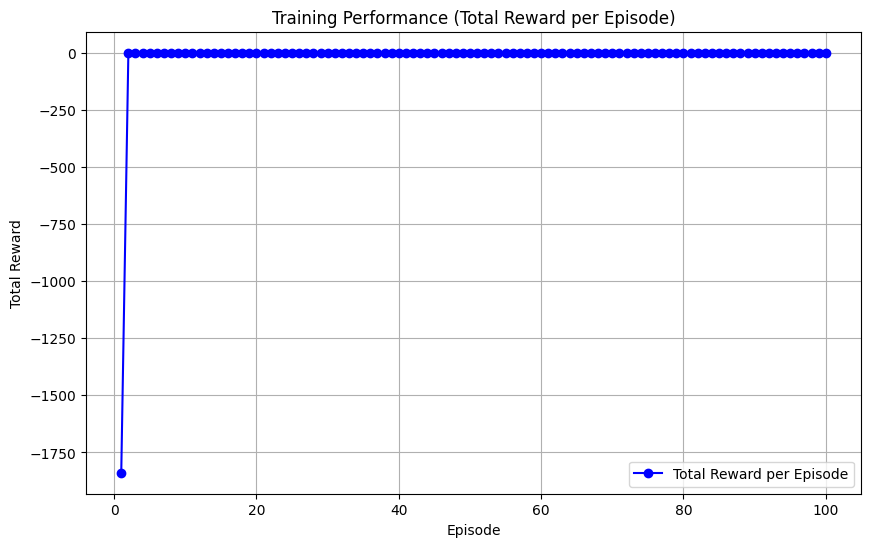

In [3]:
# Save Q-table after training
save_q_table(Q_TABLE_FILE)

# --- Visualization ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPISODES + 1), episode_rewards, label="Total Reward per Episode", color="blue", marker="o")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Performance (Total Reward per Episode)")
plt.legend()
plt.grid(True)
plt.show()

# Close SUMO connection
traci.close()

### **2 - Hyperparmeter-tunning:**

In [5]:
def train(EPSILON=0.1, GAMMA=0.9, ALPHA=0.001, NUM_EPISODES=100):

    # --- Training Loop ---
    traci.start(["sumo", "-c", r"..\sumo_config\simulation.sumocfg"])  # Update with your SUMO config file
    episode_rewards = []  # To store rewards per episode

    for episode in range(NUM_EPISODES):
        state = get_state()
        total_reward = 0
        
        while traci.simulation.getMinExpectedNumber() > 0:
            action = choose_action(state)
            traci.trafficlight.setPhase("J7", action)  # Apply action (update traffic light phase)
            traci.simulationStep()  # Step simulation
            
            next_state = get_state()
            
            # Calculate reward based on traffic metrics
            reward = calculate_reward(state)
            
            # Update Q-table
            update_q_table(state, action, reward, next_state)
            
            state = next_state
            total_reward += reward
            
            # Check for termination condition (if needed)
            if traci.simulation.getTime() > 1000:  # End after 1000 seconds
                break
        
        episode_rewards.append(total_reward)  # Store total reward for the episode
        print(f"Episode {episode + 1}/{NUM_EPISODES}, Total Reward: {total_reward}")

    traci.close()

    return episode_rewards, q_table

In [6]:
EPSILONS = [0, 1, 0.1, 0.01]
ALPHAS = [0.001,0.1, 0.2, 0.5, 0.7]
GAMMAS = [0.7, 0.9, 0.8]

results_epsilon = []
results_gammmas = []
results_alphas = []


for EPSILON in  EPSILONS:
    result = train(EPSILON=EPSILON)
    results_epsilon.append([EPSILON, result[0]])
for GAMMA in  GAMMAS:
    result = train(GAMMA=GAMMA)
    results_gammmas.append([GAMMA, result[0]])
for ALPHA in  ALPHAS:
    result = train(ALPHA = ALPHA )
    results_alphas.append([ALPHA, result[0]])

Episode 1/100, Total Reward: -1546.3663087694758
Episode 2/100, Total Reward: 0
Episode 3/100, Total Reward: 0
Episode 4/100, Total Reward: 0
Episode 5/100, Total Reward: 0
Episode 6/100, Total Reward: 0
Episode 7/100, Total Reward: 0
Episode 8/100, Total Reward: 0
Episode 9/100, Total Reward: 0
Episode 10/100, Total Reward: 0
Episode 11/100, Total Reward: 0
Episode 12/100, Total Reward: 0
Episode 13/100, Total Reward: 0
Episode 14/100, Total Reward: 0
Episode 15/100, Total Reward: 0
Episode 16/100, Total Reward: 0
Episode 17/100, Total Reward: 0
Episode 18/100, Total Reward: 0
Episode 19/100, Total Reward: 0
Episode 20/100, Total Reward: 0
Episode 21/100, Total Reward: 0
Episode 22/100, Total Reward: 0
Episode 23/100, Total Reward: 0
Episode 24/100, Total Reward: 0
Episode 25/100, Total Reward: 0
Episode 26/100, Total Reward: 0
Episode 27/100, Total Reward: 0
Episode 28/100, Total Reward: 0
Episode 29/100, Total Reward: 0
Episode 30/100, Total Reward: 0
Episode 31/100, Total Reward: 0

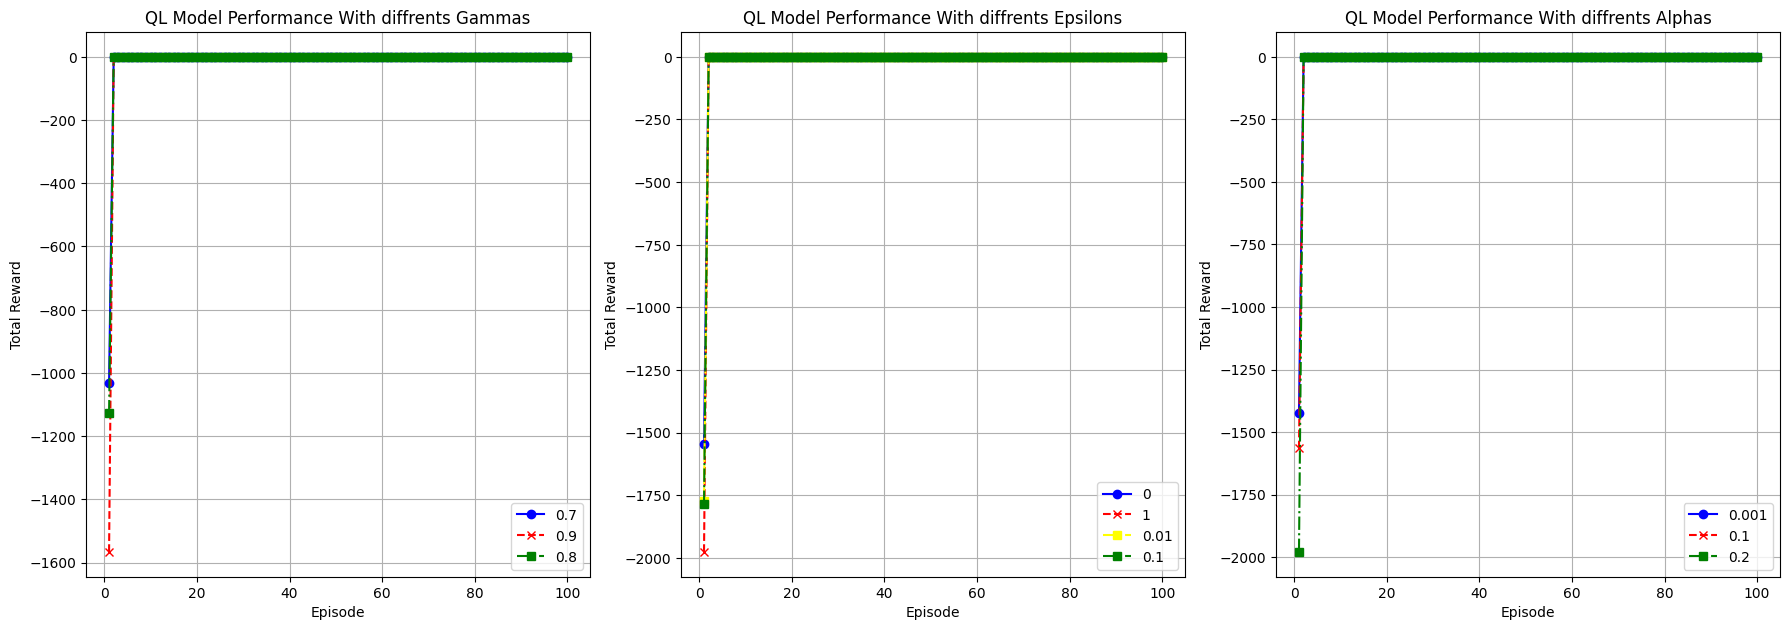

In [20]:
# --- Visualization ---
plt.figure(figsize=(18, 12))  # Adjust the figure size



# Plot 1: Diffrent Gammas
plt.subplot(2, 3, 1)
plt.plot(range(1, NUM_EPISODES + 1), results_gammmas[0][1], label=f"{results_gammmas[0][0]}", color="blue", linestyle='-', marker="o")
plt.plot(range(1, NUM_EPISODES + 1), results_gammmas[1][1], label=f"{results_gammmas[1][0]}", color="red", linestyle='--', marker='x')
plt.plot(range(1, NUM_EPISODES + 1), results_gammmas[2][1], label=f"{results_gammmas[2][0]}", color="green", linestyle='-.', marker='s')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("QL Model Performance With diffrents Gammas")
plt.legend()
plt.grid(True)

# Plot 2: Diffrent Epsilons
plt.subplot(2, 3, 2)  # (rows, cols, position)
plt.plot(range(1, NUM_EPISODES + 1), results_epsilon[0][1], label=f"{results_epsilon[0][0]}", color="blue", linestyle='-', marker="o")
plt.plot(range(1, NUM_EPISODES + 1), results_epsilon[1][1], label=f"{results_epsilon[1][0]}", color="red", linestyle='--', marker='x')
plt.plot(range(1, NUM_EPISODES + 1), results_epsilon[3][1], label=f"{results_epsilon[3][0]}", color="yellow", linestyle='-.', marker='s')
plt.plot(range(1, NUM_EPISODES + 1), results_epsilon[2][1], label=f"{results_epsilon[2][0]}", color="green", linestyle='-.', marker='s')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("QL Model Performance With diffrents Epsilons")
plt.legend()
plt.grid(True)

# Plot 3: Diffrent Alphas
plt.subplot(2, 3, 3)
plt.plot(range(1, NUM_EPISODES + 1), results_alphas[0][1], label=f"{results_alphas[0][0]}", color="blue", linestyle='-', marker="o")
plt.plot(range(1, NUM_EPISODES + 1), results_alphas[1][1], label=f"{results_alphas[1][0]}", color="red", linestyle='--', marker='x')
plt.plot(range(1, NUM_EPISODES + 1), results_alphas[2][1], label=f"{results_alphas[2][0]}", color="green", linestyle='-.', marker='s')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("QL Model Performance With diffrents Alphas")
plt.legend()
plt.grid(True)


# Show all plots
plt.tight_layout()  # Adjust spacing between plots
plt.show()

**- Best parameter selection : Gamma of 0.7, Epsilon of 0.01, Alpha of 0.001**

In [32]:
result, table = train(EPSILON=0.01, GAMMA=0.7, ALPHA=0.001)
save_q_table(Q_TABLE_FILE)

Episode 1/100, Total Reward: -1590.831492740121
Episode 2/100, Total Reward: 0
Episode 3/100, Total Reward: 0
Episode 4/100, Total Reward: 0
Episode 5/100, Total Reward: 0
Episode 6/100, Total Reward: 0
Episode 7/100, Total Reward: 0
Episode 8/100, Total Reward: 0
Episode 9/100, Total Reward: 0
Episode 10/100, Total Reward: 0
Episode 11/100, Total Reward: 0
Episode 12/100, Total Reward: 0
Episode 13/100, Total Reward: 0
Episode 14/100, Total Reward: 0
Episode 15/100, Total Reward: 0
Episode 16/100, Total Reward: 0
Episode 17/100, Total Reward: 0
Episode 18/100, Total Reward: 0
Episode 19/100, Total Reward: 0
Episode 20/100, Total Reward: 0
Episode 21/100, Total Reward: 0
Episode 22/100, Total Reward: 0
Episode 23/100, Total Reward: 0
Episode 24/100, Total Reward: 0
Episode 25/100, Total Reward: 0
Episode 26/100, Total Reward: 0
Episode 27/100, Total Reward: 0
Episode 28/100, Total Reward: 0
Episode 29/100, Total Reward: 0
Episode 30/100, Total Reward: 0
Episode 31/100, Total Reward: 0


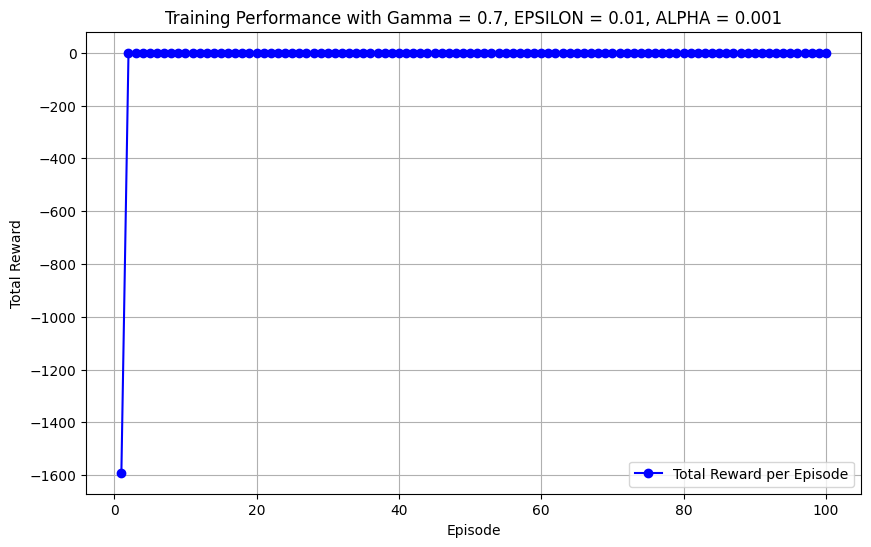

In [34]:
# --- Visualization ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPISODES + 1), result, label="Total Reward per Episode", color="blue", marker="o")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Performance with Gamma = 0.7, EPSILON = 0.01, ALPHA = 0.001")
plt.legend()
plt.grid(True)
plt.show()